# HMC Monte-Carlo sampling from a power-law mass function

We assume a set of masses drawn from a power-law distribution. The distribution
is defined by 3 parameters: the index $\alpha$, the lower and upper mass range
$M_{min}$, $M_{max}$.
    $$\theta = { \alpha, M_{min}, M_{max} }$$
    
Let's suppose known $M_{min}$ and $M_{max}$ such that we only look at the posterior of
$\alpha$. We know that in fact $M_{max}$ and $M_{min}$ cannot be infered because they are
most likely outside from the mass range covered by the data set.
    $$dN/dM = Z \times M ^ -\alpha$$
where
\begin{equation}
     Z = \int_{M_{min}}^{M_{max}} dN/dM dM \\
       = \frac{(1 - \alpha)}{(M_{max} ^ {1 - \alpha} - M_{min} ^ {1 - \alpha})}
\end{equation}

we define $\beta = 1 - \alpha$
    $$Z = \frac{\beta}{M_{max} ^ \beta - M_{min} ^ \beta}$$
    
For this test, we neglect errors of stellar mass observations.
Least-square likelihood could be used in this case. However instead we can make
use that the mass function is the PDF of our data. Thus, We can derive the likelihood as
    $$L(Data; \alpha) = \prod_k Z \times M_k ^ \alpha$$
and because numerically more stable and usually makes the math simpler we
define the  log-likelhood $\ln L(Data; \alpha)$ as
    $$\ln L(Data; \alpha) = N \ln(Z) - \alpha  \sum_k \ln(M_k)$$
    
    
Note that the data set only enters via $D = \sum_k \ln(M_k)$, term that is
completely independent of the fit parameter. Hence this term can be computed
once and for all at beginning. Therefore, the length of the data set does not
slow down the computations. (This may not be true for non-perfectly known masses)

This experiment aims at implementing Hamiltonian Monte-Carlo method. This
method involves a stepsize as the traditional MH (Metropolis Hastings) method
but improves efficiency by updating this value using the local gradient of the
objective function $\ln L$.

Hamiltonian Monte-Carlo makes use of the fact, that we can write our
log-likelihood as an energy similarly to dynamic systems:
    $$L = \exp( \ln(L) ) = \exp( -E )$$
So that $E = - \ln(L)$ is the energy of any point in the parameter space.

Maximazing the likelihood becomes finding the minimum state of energy.
The algorithm then uses Hamiltonian dynamics to modify the way how candidates
are proposed by computing the total energy of a local point by:
    $$H = \frac{1}{2} p ^ 2 + E$$
where $p ^ 2$ is the impulse (movement between 2 steps)
$p$ is proposed by doing random leap frog steps locally using the gradient of the
objective function.

In our case the gradient function of the log-likelihood is:
\begin{eqnarray}
    \frac{d \ln L}{d \theta} &=& \frac{d \ln L}{d \alpha}\\
    &=& -D - \frac{N}{\beta} \times \left[ 1 + Z \times (\ln(M_{min}) \times M_{min} ^ \beta - \ln(M_{max}) \times M_{max} ^ \beta)\right]
\end{eqnarray}

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import random as random
import matplotlib.pyplot as plt
import time
from nuts import nuts6, NutsSampler_fn_wrapper

# set the seed
random.seed(1)


def random_PowerLaw(N, alpha, M_min, M_max):
    """
    Draw random samples from a power-law defined over M_min, M_max.
        dN/dM = Z x M ** -alpha
    INPUTS
    ------
    N: int
        number of samples.
    alpha: float
        power-law index.
    M_min: float
        lower bound of mass interval.
    M_max: float
        upper bound of mass interval.
    OUTPUTS
    -------
    masses: ndarray[float, ndim=1]
        list of N masses drawn from the power-law
    """
    beta = 1. - alpha
    x = np.random.uniform(0., 1., N)
    if beta == 0:
        y = M_min * np.exp( np.log(M_max / M_min) * x )
    else:
        y = ((M_max ** beta - M_min ** beta) * x + M_min ** beta) ** (1. / beta)
    return y


def logLikelihood(theta, D, N, M_min, M_max):
    """
    Define logarithmic likelihood function.
    theta: ndarray[float, ndim=1]
        array of fit params
    D: float
        data
        normalization constant, sum_n log(M_n)
    N: int
        number of data points
    M_min: float
        lower limit of mass interval
    M_max: float
        upper limit of mass interval
    """
    # extract alpha
    alpha = theta[0]
    beta = 1.0 - alpha

    # Compute normalisation constant.
    if beta == 0:
        c = np.log(M_max / M_min)
    else:
        c = beta / (M_max ** beta - M_min ** beta)

    # return log likelihood.
    return N * np.log(c) - alpha * D


def grad_logLikelihood(theta, D, N, M_min, M_max):
    """Define gradient of log-likelihood
    d lnL / d theta (here only one dim alpha
    theta: ndarray[float, ndim=1]
        array of fit params
    D: float
        data
        normalization constant, sum_n log(M_n)
    N: int
        number of data points
    M_min: float
        lower limit of mass interval
    M_max: float
        upper limit of mass interval
    """
    alpha = theta[0]  # extract alpha
    beta = 1.0 - alpha

    #Convert limits from M to logM.
    logMmin = np.log(M_min)
    logMmax = np.log(M_max)

    if beta != 0:
        grad = logMmin * M_min ** beta - logMmax * M_max ** beta
        grad = 1.0 + grad * beta / (M_max ** beta - M_min ** beta)
        grad = -D - N * grad / beta
    else:
        grad = float(N)

    return np.array([grad])

In [3]:
# Generate toy data.
Nstars = int(1e5)
alpha  = 2.35
M_min  = 1.0
M_max  = 100.0
Masses = random_PowerLaw(Nstars, alpha, M_min, M_max)
LogM   = np.log(Masses)
D      = np.mean(LogM) * Nstars

#NUTS pars
M, Madapt = 1000, 1000
theta0 = np.asarray([3.0])
delta = 0.5

nuts_fn = NutsSampler_fn_wrapper(logLikelihood, grad_logLikelihood, D, Nstars, M_min, M_max)
#nuts_fn.verbose = True

t_start = time.time()
print("Starting Sampling at %s" % time.ctime(t_start))
A, lnprob, epsilon = nuts6(nuts_fn, M, Madapt, theta0, delta)
t_stop = time.time()
print("Sampling Completed in %0.2f seconds" % (t_stop - t_start))

Starting Sampling at Mon Jul 16 16:01:59 2018
find_reasonable_epsilon= 0.0078125


/srv/conda/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: overflow encountered in double_scalars
/srv/conda/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in log
/srv/conda/lib/python3.6/site-packages/ipykernel_launcher.py:91: RuntimeWarning: overflow encountered in double_scalars
/srv/conda/lib/python3.6/site-packages/ipykernel_launcher.py:92: RuntimeWarning: overflow encountered in double_scalars
/srv/conda/lib/python3.6/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in double_scalars
/home/jovyan/nuts/nuts.py:177: RuntimeWarning: overflow encountered in exp
  alphaprime = min(1., np.exp(joint - joint0))


Sampling Completed in 0.21 seconds


Mean:  2.350359000945028
Alpha = 2.350454340625697 (+0.00430382275886787 / - 0.004864395637874441)


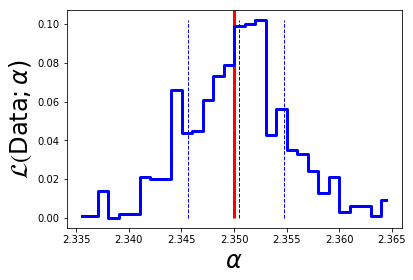

In [4]:
plt.figure(1)

# Print Monte-Carlo estimate of alpha.
print("Mean:  " + str(np.mean(A)))
per = np.percentile(A, [16, 50, 84])
print("Alpha = {} (+{} / - {})".format( per[1], per[2] - per[1], per[1] - per[0] ))

n, b = np.histogram(A, 30)
x = 0.5 * (b[:-1] + b[1:])
y = n.astype(float) / n.sum()
plt.step(x, y, color='b', lw=3, where='mid')
plt.vlines(per, 0., max(y), linestyle='--', color='b', lw=1)

ylim = plt.ylim()
plt.vlines(alpha, 0, ylim[1], color='r', lw=3)
plt.ylim(ylim)
plt.xlabel(r'$\alpha$', fontsize=24)
plt.ylabel(r'$\cal L($Data$;\alpha)$', fontsize=24)
plt.show()